In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Read in 
df11 = pd.read_csv('../data/df11.csv')

In [3]:
# Inspect
df11

,day,x1,x2,y
0,1,6.267497,C,4.603924
1,1,6.592165,C,2.319000
2,1,7.461689,A,14.341126
3,1,7.548916,A,14.588287
4,1,8.313763,B,5.284077
...,...,...,...,...
9995,60,16.125031,C,14.914215
9996,60,16.477850,C,5.508371
9997,60,16.824277,C,10.717834
9998,60,17.722692,C,9.113135


In [4]:
# Split data sets
df11_01_30 = df11[df11.day <= 30]
df11_31_45 = df11[(30 < df11.day) & (df11.day <= 45)]
df11_46_60 = df11[45 < df11.day]

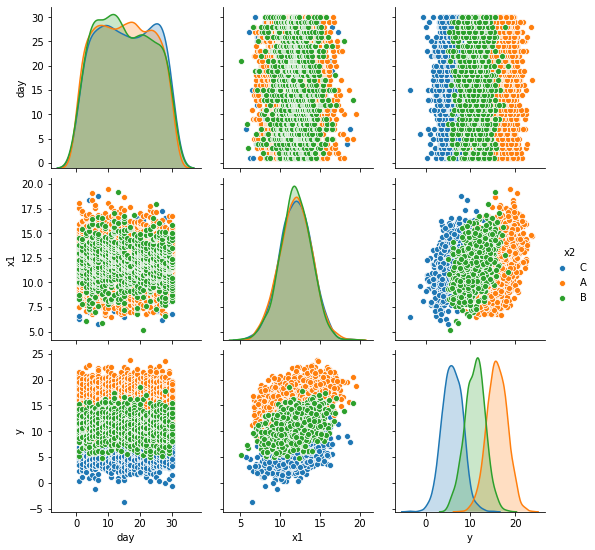

In [5]:
# Quick plot
sb.pairplot(df11_01_30, hue='x2')

# Build model on days 1-30

Stategy:

- Days 1-20 train, days 21-30 test (this data set is simple enough that I'll skip the holdout portion)
- Simple glm

In [6]:
# Split train/test/holdout
df11_01_30_train = df11_01_30[df11_01_30.day <= 20]
df11_01_30_test = df11_01_30[df11_01_30.day > 20]

# Check counts
print(f'''
Train: {df11_01_30_train.shape}
Test: {df11_01_30_test.shape}
''')


Train: (3382, 4)
Test: (1591, 4)



In [7]:
# Fit model
glm_01_30_train = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_01_30_train
).fit()

# Summarize
glm_01_30_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     4676.
Date:                Tue, 11 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:14:32   Log-Likelihood:                -7176.6
No. Observations:                3382   AIC:                         1.436e+04
Df Residuals:                    3378   BIC:                         1.439e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1519      0.212     47.913      0.000       9.736      10.567
x2[T.B]       -4.9466      0.090    -54.874      0.000      -5.123      -4.770
x2[T.C]      -10.0899      0.090   -111.863      0.000     -10.267      -9.913
x1             0.4881      0.017     28.275      0.000       0.454       0.522
==============================================================================
Omnibus:                        4.244   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                4.574
Skew:                          -0.031   Prob(JB):                        0.102
Kurtosis:                       3.169   Cond. No.                         75.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Overall AMSE on training
def mse(actual, pred):
    err = pred - actual
    return err ** 2

def amse(mse):
    return np.sum(mse) / len(mse)

amse(mse(df11_01_30_train['y'], glm_01_30_train.predict(df11_01_30_train)))

4.080115696445697

In [9]:
# Overall AMSE on testing
amse(mse(df11_01_30_test['y'], glm_01_30_train.predict(df11_01_30_test)))

4.270693095321454

A bit worse (0.2 AMSE, ~5% reduction).

Let's look at by-day AMSE

In [10]:
# AMSE by day
def amse_by_day(df, model):
    # Get predictions
    df = df.assign(p = model.predict(df))
    
    # Get MSE
    df['mse'] = df.apply(lambda x: mse(x.y, x.p), axis=1)
    
    # Aggregate
    df_agg = (
        df
        .groupby('day')
        .agg(
            n=('day', 'count'),
            mse_total=('mse', 'sum'),
            amse=('mse', lambda x: amse(x)),
        )
        .reset_index()
        .sort_values('day')
    )
    
    return df_agg

df11_01_30_train_amse = amse_by_day(df11_01_30_train, glm_01_30_train)
df11_01_30_test_amse = amse_by_day(df11_01_30_test, glm_01_30_train)

# Inspect the first
df11_01_30_train_amse

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


,day,n,mse_total,amse
0,1,154,646.646967,4.199006
1,2,155,587.089859,3.787677
2,3,152,640.516954,4.213927
3,4,158,675.852376,4.277547
4,5,176,575.129974,3.267784
5,6,185,686.619622,3.711457
6,7,171,690.871632,4.040185
7,8,174,695.309163,3.996030
8,9,166,672.728487,4.052581
9,10,175,741.888266,4.239362


(0, 6)

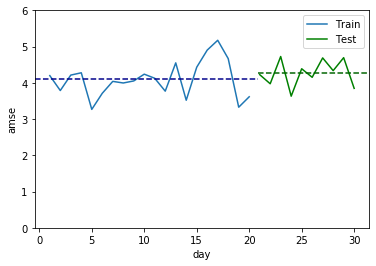

In [11]:
# Plot

# AMSEs by day
sb.lineplot(data=df11_01_30_train_amse, x='day', y='amse', label='Train')
sb.lineplot(data=df11_01_30_test_amse, x='day', y='amse', label='Test', color='green')

# AMSE means for reference
plt.axhline(df11_01_30_train_amse.amse.mean(), xmax=2/3, color='darkblue', ls='--')
plt.axhline(df11_01_30_test_amse.amse.mean(), xmin=2/3, color='darkgreen', ls='--')

plt.ylim(0, 6)

Fit seems reasonable, so refit same model on whole data

In [12]:
# Fit model
glm_01_30 = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_01_30
).fit()

# Summarize
glm_01_30.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     6920.
Date:                Tue, 11 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:14:33   Log-Likelihood:                -10589.
No. Observations:                4973   AIC:                         2.119e+04
Df Residuals:                    4969   BIC:                         2.121e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0405      0.178     56.278      0.000       9.691      10.390
x2[T.B]       -4.9676      0.075    -65.954      0.000      -5.115      -4.820
x2[T.C]      -10.0345      0.074   -135.972      0.000     -10.179      -9.890
x1             0.4958      0.015     34.095      0.000       0.467       0.524
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.778
Skew:                          -0.015   Prob(JB):                        0.678
Kurtosis:                       3.053   Cond. No.                         75.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# Overall AMSE on testing
amse(mse(df11_01_30['y'], glm_01_30.predict(df11_01_30)))

4.1400460054524935

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


(0, 6)

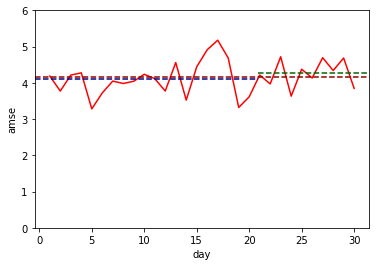

In [14]:
# Plot out AMSEs
df11_01_30_amse = amse_by_day(df11_01_30, glm_01_30)

# AMSEs by day
sb.lineplot(data=df11_01_30_amse, x='day', y='amse', color='red')

# AMSE means for reference
plt.axhline(df11_01_30_amse.amse.mean(), color='darkred', ls='--')

# AMSE means for reference
plt.axhline(df11_01_30_train_amse.amse.mean(), xmax=2/3, color='darkblue', ls='--')
plt.axhline(df11_01_30_test_amse.amse.mean(), xmin=2/3, color='darkgreen', ls='--')

plt.ylim(0, 6)

As expected, performs slightly worse on original training data but better than on test data (because that's feeding into the model now).

# Extend to days 31-45

In [15]:
# Overall AMSE
amse(mse(df11_31_45['y'], glm_01_30.predict(df11_31_45)))

5.000134425888234

Noticably worse (slightly less than 25%)

In [16]:
# Daily AMSEs
df11_31_45_amse = amse_by_day(df11_31_45, glm_01_30)
df11_31_45_amse

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


,day,n,mse_total,amse
0,31,153,580.872111,3.796550
1,32,158,676.985327,4.284717
2,33,160,740.787972,4.629925
3,34,185,789.438790,4.267237
4,35,161,930.086138,5.776933
5,36,190,964.464658,5.076130
6,37,176,847.927265,4.817769
7,38,160,805.685759,5.035536
8,39,154,739.944200,4.804832
9,40,164,881.007037,5.371994


<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


(0, 6)

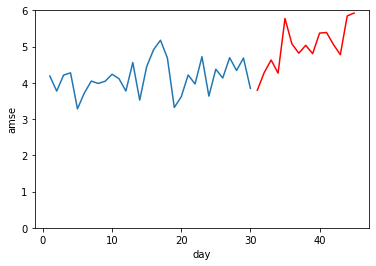

In [17]:
# Plot out AMSEs
df11_01_30_amse = amse_by_day(df11_01_30, glm_01_30)

# AMSEs by day - Days 1-30
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')

# AMSEs by day - Days 31-45
sb.lineplot(data=df11_31_45_amse, x='day', y='amse', color='red')

plt.ylim(0, 6)

It looks like the model is, on average, getting worse as days increases.

So now the important question: **What do we do about it?**

This depends a lot on the use case:

- If we were working in auto insurance where it is a long process to deploy a pricing model (car insurance being legally required makes it a "public good" and hence subject to a regulation and scrutiny), then there's probably not much we can do about it in the short term.
- If we were working in digital marketing where a variety of things can change (sometimes very rapidly) about what we are trying to predict, then it might make sense to regularly (and maybe automatically) refit the model (or use "online" models that continuously learn).

In either case, it's worthwhile to try to understand **why** this is changing.  Some common things that can be happening, all generally under an umbrella called "model drift":

- "Distribution drift" - The distribution of the predictor variables changes
    - E.g. since the model is getting worse, maybe the feature combinations with the worst predictions are becoming more common and skewing the results to look worse
- "Effect drift" - The relationship between your predictors and the target variable changing
    - E.g. since the model is getting worse, maybe certain features are becoming less predictive or a variable that previously seemed unpredictive is becoming more predictive
    
Let's investigate both here.

### Distributional drift

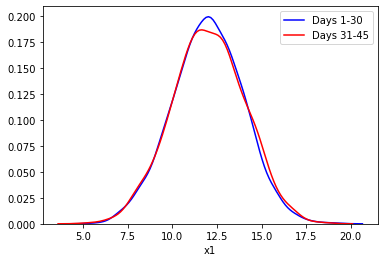

In [18]:
# x1
sb.distplot(df11_01_30['x1'], hist=False, color='blue', label='Days 1-30')
sb.distplot(df11_31_45['x1'], hist=False, color='red', label='Days 31-45')

<ipython-input-19-eb89008b1f62>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


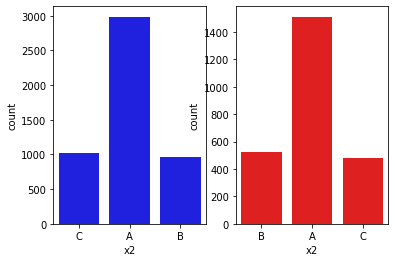

In [19]:
# x2
fig, ax = plt.subplots(1,2)
sb.countplot(df11_01_30['x2'], color='blue', label='Days  1-30', ax=ax[0])
sb.countplot(df11_31_45['x2'], color='red', label='Days 31-45', ax=ax[1])
fig.show()

Doesn't seem to be much difference here.

### Effect drift

<ipython-input-20-7d3371dcf9d9>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


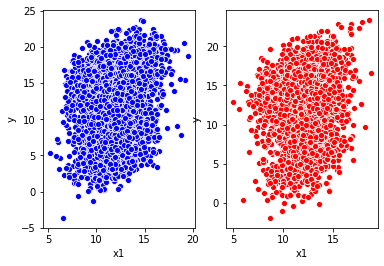

In [20]:
# x1
fig, ax = plt.subplots(1,2)
sb.scatterplot(data=df11_01_30, x='x1', y='y', color='blue', ax=ax[0])
sb.scatterplot(data=df11_31_45, x='x1', y='y', color='red', ax=ax[1])
fig.show()

Can't tell much from this, let's try the univariate plots.

In [21]:
def plot_univariate(df, x, y, model_fit, n_bins=10):
    # Create copy of dataframe
    df = df.copy()
    
    # Add prediction
    df = df.assign(p = model_fit.predict(df))
    
    # If x is numeric, bin into groups
    if df[x].dtype in (np.int64, np.float64):
        df[x] = pd.cut(df[x], n_bins).apply(str)
    
    # Aggregate
    df_agg = (
        df
        .groupby(x)
        .agg(
            n=(y, 'count'),
            y_mean=(y, 'mean'),
            y_sd=(y, 'std'),
            p_mean=('p', 'mean'),
            p_sd=('p', 'std'),
        )
        .reset_index()
    )
    
    print(df_agg)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
    
    # First plot: Counts
    ax1.bar(x, 'n', data=df_agg)
    
    # Second plot: Average actuals and predicted
    ax2.errorbar(x, 'y_mean', yerr='y_sd', data=df_agg, label='Actual', fmt='o', capsize=10, color='green')
    ax2.errorbar(x, 'p_mean', yerr='p_sd', data=df_agg, label='Predicted', fmt='o', capsize=10, color='red')
    
    plt.legend()
    plt.show()

                 x1     n     y_mean      y_sd     p_mean      p_sd
0    (5.177, 6.623]    10   5.162459  4.134274   6.079298  3.507209
1    (6.623, 8.054]   117  11.341363  4.631949  11.027859  3.952456
2    (8.054, 9.486]   394  11.569988  4.488202  11.589004  4.040763
3   (9.486, 10.918]   931  11.970219  4.536307  12.019979  4.068679
4   (10.918, 12.35]  1386  12.792308  4.508029  12.811572  3.995793
5   (12.35, 13.781]  1209  13.426073  4.485692  13.399994  4.071107
6  (13.781, 15.213]   679  14.215014  4.556657  14.203680  4.020922
7  (15.213, 16.645]   195  14.703835  4.772391  14.562790  4.215913
8  (16.645, 18.077]    45  17.417595  2.706044  17.639486  2.441512
9  (18.077, 19.508]     7  15.281896  5.017998  15.815682  4.844892


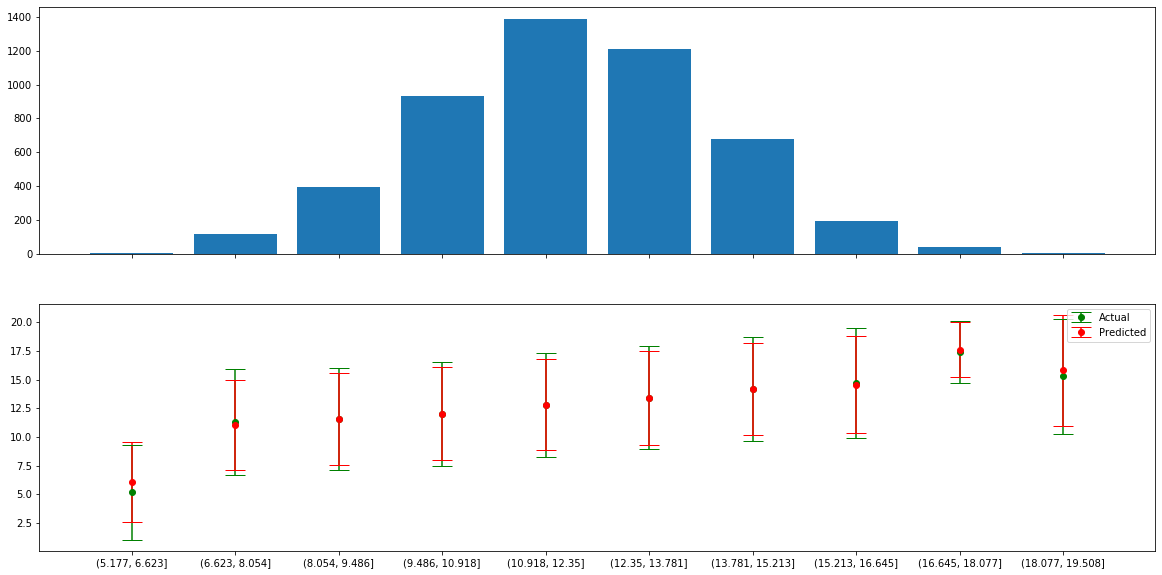

In [22]:
# x1 - Days 1-30
plot_univariate(df11_01_30, 'x1', 'y', glm_01_30)

                 x1    n     y_mean      y_sd     p_mean      p_sd
0    (4.934, 6.328]    5  10.962993  6.081656  10.842216  4.411791
1    (6.328, 7.709]   35  11.390657  3.468650  11.757469  3.193015
2    (7.709, 9.089]  154  11.339126  4.560769  11.652853  3.837165
3   (9.089, 10.469]  358  11.765473  4.401273  12.197715  3.886153
4   (10.469, 11.85]  632  11.906249  4.452539  12.344865  4.054578
5    (11.85, 13.23]  632  12.663609  4.573427  13.207305  3.996296
6    (13.23, 14.61]  429  13.473148  4.672592  14.073693  3.946636
7    (14.61, 15.99]  206  14.115226  4.423791  14.824011  3.889536
8   (15.99, 17.371]   54  14.252533  4.577293  15.351083  3.868145
9  (17.371, 18.751]    7  17.635172  5.449752  16.140584  3.990788


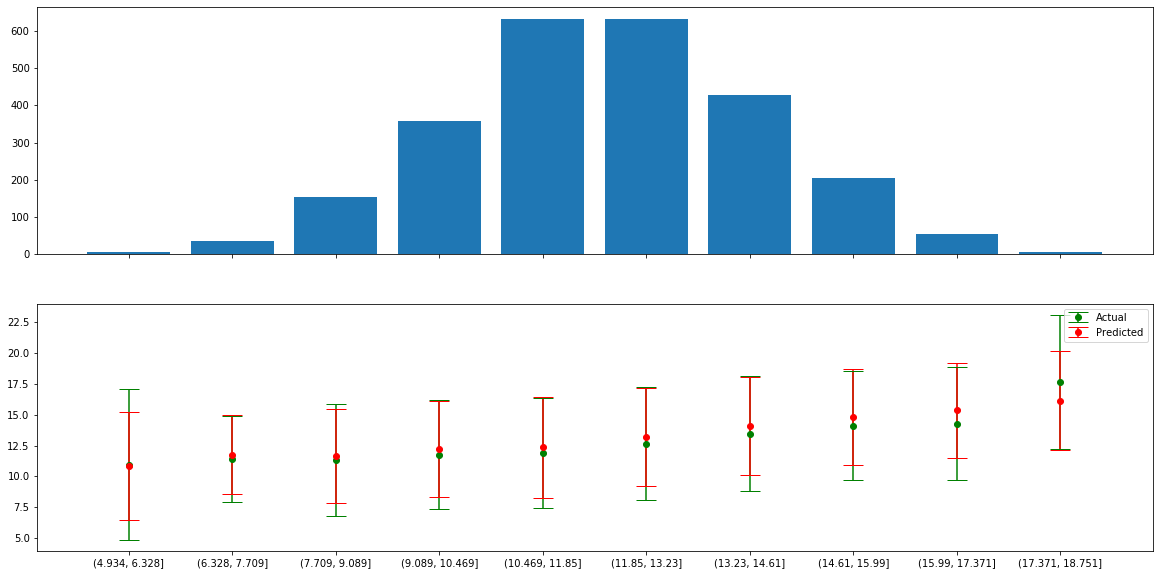

In [23]:
# x1, Days 31-45
plot_univariate(df11_31_45, 'x1', 'y', glm_01_30)

  x2     n     y_mean      y_sd     p_mean      p_sd
0  A  2985  15.989161  2.274154  15.989161  0.998437
1  B   967  11.012144  2.240908  11.012144  0.947129
2  C  1021   5.952296  2.240771   5.952296  0.977844


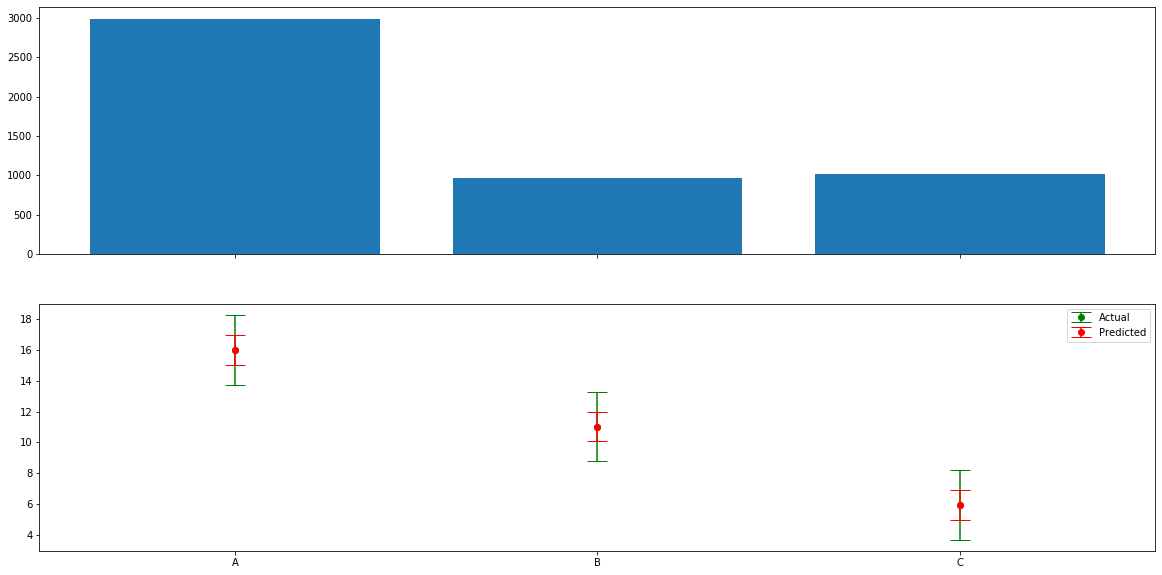

In [24]:
# x2 - Days 1-30
plot_univariate(df11_01_30, 'x2', 'y', glm_01_30)

  x2     n     y_mean      y_sd     p_mean      p_sd
0  A  1512  15.473255  2.424316  15.991660  1.035771
1  B   522  10.601123  2.173842  11.056083  0.988160
2  C   478   5.421246  2.268198   5.980448  0.939646


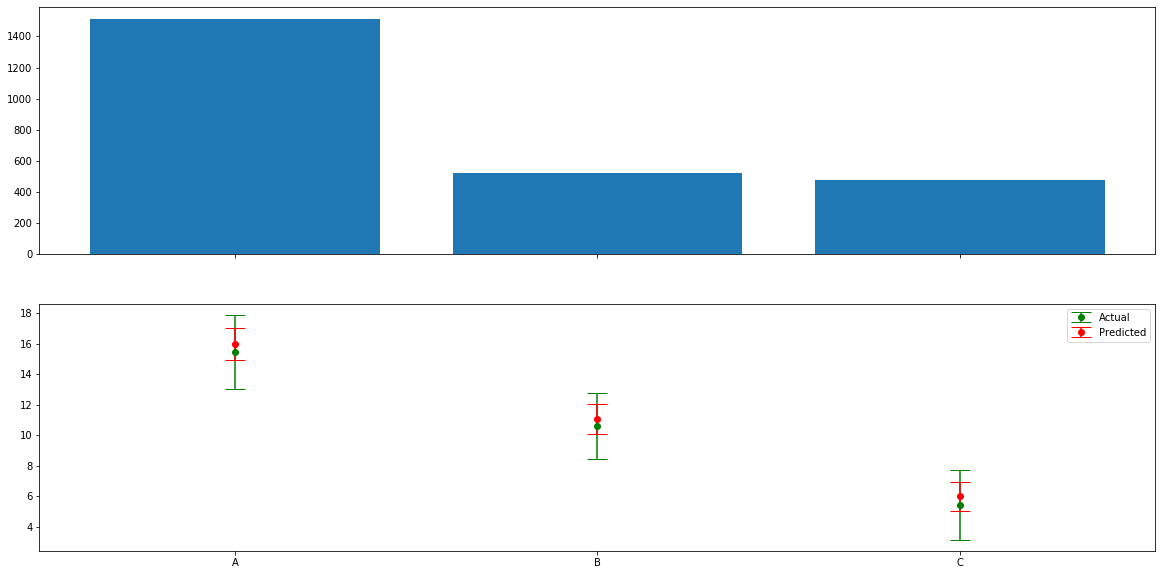

In [25]:
# x2 - Days 31-45
plot_univariate(df11_31_45, 'x2', 'y', glm_01_30)

Looks like our model is over-predicting on days 31-45 despite looking good on days 1-30.  So we have some evidence of effect drift.

For comparison, let's fit the same glm specification on days 31-40 and compare the AMSEs of this new model and the current one on days 41-45

In [26]:
# Split train/test/holdout
df11_31_45_train = df11_31_45[df11_31_45.day <= 40]
df11_31_45_test = df11_31_45[df11_31_45.day > 40]

# Check counts
print(f'''
Train: {df11_31_45_train.shape}
Test: {df11_31_45_test.shape}
''')


Train: (1661, 4)
Test: (851, 4)



In [27]:
# Fit model
glm_31_45_train = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_31_45_train
).fit()

# Summarize
glm_31_45_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1895.
Date:                Tue, 11 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:14:36   Log-Likelihood:                -3636.8
No. Observations:                1661   AIC:                             7282.
Df Residuals:                    1657   BIC:                             7303.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8569      0.320     30.843      0.000       9.230      10.484
x2[T.B]       -4.8594      0.133    -36.642      0.000      -5.120      -4.599
x2[T.C]      -10.0471      0.142    -70.521      0.000     -10.326      -9.768
x1             0.4808      0.026     18.500      0.000       0.430       0.532
==============================================================================
Omnibus:                        1.234   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                1.172
Skew:                          -0.063   Prob(JB):                        0.557
Kurtosis:                       3.033   Cond. No.                         74.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# Previous model summary for comparison
glm_01_30.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     6920.
Date:                Tue, 11 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:14:36   Log-Likelihood:                -10589.
No. Observations:                4973   AIC:                         2.119e+04
Df Residuals:                    4969   BIC:                         2.121e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0405      0.178     56.278      0.000       9.691      10.390
x2[T.B]       -4.9676      0.075    -65.954      0.000      -5.115      -4.820
x2[T.C]      -10.0345      0.074   -135.972      0.000     -10.179      -9.890
x1             0.4958      0.015     34.095      0.000       0.467       0.524
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.778
Skew:                          -0.015   Prob(JB):                        0.678
Kurtosis:                       3.053   Cond. No.                         75.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see some changes in coefficient estimates, but the 95% confidence intervals overlap so hard to draw any definitive conclusion about changing effects.  This is where partial dependence plots can be useful if we use a model framework besides GLMs.

Plot AMSEs.

In [29]:
# Previous AMSE on days 41-45
amse(mse(df11_31_45_test['y'], glm_01_30.predict(df11_31_45_test)))

5.409093326410996

In [30]:
# New AMSE on days 41-45
amse(mse(df11_31_45_test['y'], glm_31_45_train.predict(df11_31_45_test)))

4.928958945454168

Still worse than the original data but definitely better!

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)
<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


(0, 6)

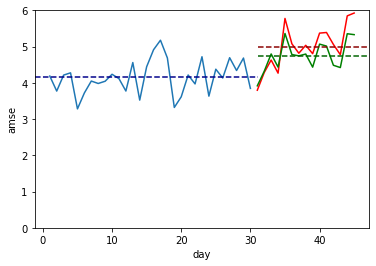

In [31]:
# Plot out AMSEs
df11_01_30_amse = amse_by_day(df11_01_30, glm_01_30)

# AMSEs by day - Days 1-30
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')

# AMSEs by day - Days 31-45 (Previous model)
sb.lineplot(data=df11_31_45_amse, x='day', y='amse', color='red')

# AMSEs by day - Days 31-45 (New model)
df11_31_45_amse_train = amse_by_day(df11_31_45, glm_31_45_train)
sb.lineplot(data=df11_31_45_amse_train, x='day', y='amse', color='green')

# AMSE means for reference
plt.axhline(df11_01_30_amse.amse.mean(), xmax=2/3, color='darkblue', ls='--')
plt.axhline(df11_31_45_amse.amse.mean(), xmin=2/3, color='darkred', ls='--')
plt.axhline(df11_31_45_amse_train.amse.mean(), xmin=2/3, color='darkgreen', ls='--')

plt.ylim(0, 6)

The new model seems to do slightly worse on the first few days but after that does better every day.  And it looks like the difference might be increasing towards the latter days.

So now we need to decide **what** to do about this.  Our options:

- Continue using the previous model
    - Doesn't make sense because more recent data seems to help the model
- Build a new model including both the previous data and the new data
    - Questionable because of the effect drift we seem to have found earlier
    - We could also "weight" the more recent data to give it more importance when fitting the model (e.g. weight each observation in days 31-45 with `1` and days 0-30 with something less than that like `0.5`)
- Build a model using only the new data
    - Throws away all of that previous data and forces us to extend a new model on half of the data we previously had
- Build a model and use `day` as a predictor to control for the 
    - Increases the complexity of the model and forces us to extraplote that this trend will continue into the future (e.g. days 46+ will exhibit this trend and not change again)
    
There is no easy answer to this type of situation, and answers might vary depending on the problem.  With what we know right now for this problem (and assuming that the problem is low stakes), let's just refit on the new data.  Fitting a new model with all of the data (weighted or not) will just look at least slightly worse on the most recent data.

In reality, we might try multiple different approaches (e.g. by deploying multiple models to production and evaluating over upcoming days).

In [32]:
# Fit model
glm_31_45 = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_31_45
).fit()

# Summarize
glm_31_45.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     2901.
Date:                Tue, 11 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:14:37   Log-Likelihood:                -5513.3
No. Observations:                2512   AIC:                         1.103e+04
Df Residuals:                    2508   BIC:                         1.106e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2811      0.262     39.210      0.000       9.767      10.795
x2[T.B]       -4.9000      0.110    -44.393      0.000      -5.116      -4.684
x2[T.C]      -10.0724      0.114    -88.286      0.000     -10.296      -9.849
x1             0.4325      0.021     20.268      0.000       0.391       0.474
==============================================================================
Omnibus:                        1.309   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                1.343
Skew:                          -0.054   Prob(JB):                        0.511
Kurtosis:                       2.967   Cond. No.                         74.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)
<ipython-input-8-5c78bd39440a>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


(0, 6)

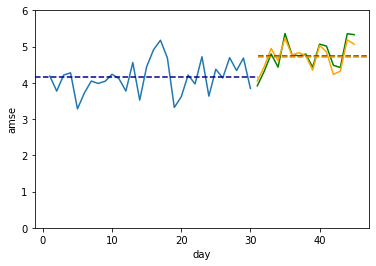

In [33]:
# Plot out AMSEs
df11_01_30_amse = amse_by_day(df11_01_30, glm_01_30)

# AMSEs by day - Days 1-30
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')

# AMSEs by day - Days 31-45 (New model on training)
sb.lineplot(data=df11_31_45_amse_train, x='day', y='amse', color='green')

# AMSEs by day - Days 31-45 (New model on days 31-45)
df11_31_45_amse = amse_by_day(df11_31_45, glm_31_45)
sb.lineplot(data=df11_31_45_amse, x='day', y='amse', color='orange')

# AMSE means for reference
plt.axhline(df11_01_30_amse.amse.mean(), xmax=2/3, color='darkblue', ls='--')
plt.axhline(df11_31_45_amse_train.amse.mean(), xmin=2/3, color='darkgreen', ls='--')
plt.axhline(df11_31_45_amse.amse.mean(), xmin=2/3, color='darkorange', ls='--')

plt.ylim(0, 6)

# Extend to days 46-60

In [34]:
# Overall AMSE
amse(mse(df11_46_60['y'], glm_31_45.predict(df11_46_60)))

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'D' does not match any of the expected levels (expected: ['A', 'B', 'C'])
    y ~ x1 + x2
             ^^

It looks like we have a new value of x2.  Fun!

Ideally we build our models to be able to handle situations like this.  Here are a number of things we can do:

- Have the model error out completely
    - But this is not acceptable in situations where models need to quickly return a prediction and have near 100% up-time (e.g. fraud modelling)
- Have the model error out with some sort of "fallback" option
    - For example, if a model errors out at scoring time due to a new value simply return the previously estimated overall mean
- Score the model usings only 0s for this category
    - For this linear regression (and generally regression as a whole), this means that "D" will be similar to the reference category for `x2` ("A"), which makes some assumptions about 
    - For tree models where we just pass in a matrix and don't have the concept of reference categories, it means that there would never be a "positive" split on "D" (e.g. if splitting on "X" and "Not X", we'll always go to "Not X")
- Remove rows with `x2 = 'D'`
    - But, generally, we shouldn't remove data because this likely reflects something meaningful (e.g. a shift in our underlying data or a new data collection error)
- Use a modelling approach that can learn about new values as they appear
    - Requires a lot of upkeep and monitoring to make sure we are balancing fitting on new values with not rapidly changing predictions due to noisy data
    - Also requires us to know when we expect to see the "actual" information to use for predicting.  Here it seems like we get the data alongside the predictors, which sometimes is nearly the case (e.g. it could be a system with quick feedback loops) but sometimes there is a long latency between needing to create a prediction and knowing how well that prediction did.
- Refit the model once we have some data on the new values
    - Still need an interim solution until we get enough data on the new value to refit the model
    - Same caveat in the previous bullet about knowing when we will receive 

The best choice really depends on the context.

- For example, if we need to have a model that can work with any new potential value despite not having seen it, we could create an "Other" category that all new values get lumped into for returning a prediction.
- Conversely, we could return a "prediction" the results in a particular business process happening (e.g. "send this video to a human to look at because we have no idea what to do with it")

Keep in mind that different modelling frameworks and implementations can need different ways of preventing or dealing with these errors.  For statsmodel formula-built models, it will yell at us for new values in a way that is generally informative but trees can natively error in a different way (e.g. it sees too many "columns" since we only pass in a matrix, or it might just ignore any columns past how many it expects and hence our features can be misidentified at scoring time because names are not tracked).

For simplicity to start, let's pretend that we noticed this before deploying our model and just refit the model on the first day we see `x2 = 'D'` to see how well it does and the following several days.

In [ ]:
# Create new data sets for convenience
df11_46_49 = df11_46_60[df11_46_60.day <= 49]
df11_46_53 = df11_46_60[df11_46_60.day <= 53]
df11_50_53 = df11_46_60[df11_46_60.day.isin([50, 51, 52, 53])]  # Only net new rows after fitting including day 49 in a model
df11_31_49 = df11_31_45.append(df11_46_49)

In [ ]:
# Fit model
glm_31_49 = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_31_49
).fit()

# Summarize
glm_31_49.summary()

In [ ]:
# Plot out AMSEs through day 53
df11_01_30_amse = amse_by_day(df11_01_30, glm_01_30)

# AMSEs by day - Days 1-30
sb.lineplot(data=df11_01_30_amse, x='day', y='amse')

# AMSEs by day - Days 31-45
sb.lineplot(data=df11_31_45_amse, x='day', y='amse', color='orange')

# AMSEs by day - Days 46-53
df11_46_53_amse = amse_by_day(df11_46_53, glm_31_49)
sb.lineplot(data=df11_46_53_amse, x='day', y='amse', color='red')

# AMSE means for reference
plt.axhline(df11_01_30_amse.amse.mean(), xmax=30/53, color='darkblue', ls='--')
plt.axhline(df11_31_45_amse.amse.mean(), xmin=30/53, xmax=45/53, color='darkorange', ls='--')
plt.axhline(df11_46_53_amse.amse.mean(), xmin=45/53, color='darkred', ls='--')

plt.ylim(0, 15)

Well, at least our model is no longer erroring!

But now we seem to have a different problem causing the predictions themselves to skyrocket.  Let's repeat our distributional and effect drift checks from before, focusing on the difference between the new model fit data (days between 31 and 49) and a few days after that (days 50 through 53).

### Distributional drift

In [ ]:
# x1
sb.distplot(df11_31_49['x1'], hist=False, color='blue', label='Days 31-49')
sb.distplot(df11_50_53['x1'], hist=False, color='red', label='Days 50-53')

In [ ]:
# x2
fig, ax = plt.subplots(1,2)
sb.countplot(df11_31_49['x2'], color='blue', label='Days 31-49', ax=ax[0], order=['A', 'B', 'C', 'D'])
sb.countplot(df11_50_53['x2'], color='red', label='Days 50-53', ax=ax[1], order=['A', 'B', 'C', 'D'])
fig.show()

Observations:

- `x1`: Some possible shift in mean but could be from relatively few days in the comparison
- `x2`: Looks like C is a bit more common after day 49, B is a bit less common, and D is becoming as common as B, but again could be influenced by having relatively few days in the comparison

### Effect drift

In [ ]:
# x1 - Days 31-49
plot_univariate(df11_31_49, 'x1', 'y', glm_31_49)

In [ ]:
# x1 - Days 50-53
plot_univariate(df11_50_53, 'x1', 'y', glm_31_49)

In [ ]:
# x2 - Days 31-49
plot_univariate(df11_31_49, 'x2', 'y', glm_31_49)

In [ ]:
# x2 - Days 50-53
plot_univariate(df11_50_53, 'x2', 'y', glm_31_49)

Exercising some caution due to only have a few days in 50-53, it looks the relationship between `x2 = 'C'` and y might be changing as well with the new data.

Since we're still in a development phase, let's test the current model with a model built only on days 49-55 and evaluate on days 56-60.

In [ ]:
# Create new data sets for convenience
df11_49_55 = df11_46_60[(49 <= df11_46_60.day) & (df11_46_60.day <= 55)]
df11_56_60 = df11_46_60[55 < df11_46_60.day]

In [ ]:
# Fit model
glm_49_55 = smf.ols(
    formula='y ~ x1 + x2',
    data=df11_49_55
).fit()

# Summarize
glm_49_55.summary()

In [ ]:
# AMSE for 31-49 momdel
amse(mse(df11_56_60['y'], glm_31_49.predict(df11_56_60)))

In [ ]:
# AMSE for 49-55 momdel
amse(mse(df11_56_60['y'], glm_49_55.predict(df11_56_60)))

Wow, more recent data looks much, much better.  Probably due to both the distributional and effect shifts we noticed earlier.

In [ ]:
# Plot out AMSEs
df11_56_60_amse_prev = amse_by_day(df11_56_60, glm_31_49)
sb.lineplot(data=df11_56_60_amse_prev, x='day', y='amse', color='red')

df11_56_60_amse_new = amse_by_day(df11_56_60, glm_49_55)
sb.lineplot(data=df11_56_60_amse_new, x='day', y='amse', color='blue')

plt.ylim(0, 15)